## (1) Data Processing
Pandas datareader allows you to [read stock information directly from the internet](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas_datareader as pdr
import datetime

In [3]:
# data import from API
start = datetime.datetime(1970,1,1)
end = datetime.datetime(2019,4,1)

# SP500
SP500 = pdr.get_data_yahoo('^GSPC',start,end)

# MSCI ACWI Index?
#ACWI = pdr.get_data_yahoo('ACWI',start,ends)

# iShares Core U.S. Aggregate Bond ETF
#bond = pdr.get_data_yahoo('AGG',start,ends)

# daily 3-Month Treasury Bill: Secondary Market Rate, unit: percent
treas3_raw = pdr.get_data_fred('DTB3', start, end)

# monthly CPI: Consumer Price Index for All Urban Consumers: All Items 
CPI = pdr.get_data_fred('CPIAUCSL', start, end)
# 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity
Y10_2 = pdr.get_data_fred('T10Y2Y', start, end)

In [4]:
# calculate index for treas3
treas3_raw.fillna(method='pad', inplace=True)
treas3_raw = treas3_raw.apply(lambda x:x/100/365)

list = [1,]
for num in range(1, len(treas3_raw)):
    list.append( list[num-1]*(1+treas3_raw['DTB3'][num]) )
treas3_raw['index'] = np.array(list)
treas3 = treas3_raw.drop('DTB3', axis=1)

In [5]:
# generate MSCI ACWI Index from csv
ACWI_raw = pd.read_csv(r'C:\Users\nxa19205\Fin_testbench\data\ACWI.csv')
ACWI_raw['Date'] = pd.to_datetime(ACWI_raw['Date'])
ACWI = ACWI_raw.set_index('Date')
ACWI['price'] = ACWI['price'].apply(lambda x: x.replace(',', '')).apply(lambda x: float(x))

In [6]:
# form the price table
SP500_adjClose = SP500.drop(axis =1, columns=['High', 'Low', 'Open', 'Close', 'Volume'])
#bond_adjClose = bond.drop(axis =1, columns=['High', 'Low', 'Open', 'Close', 'Volume'])

df= pd.concat([SP500_adjClose, ACWI, treas3], axis=1, keys=['SP500', 'ACWI', 'treas3'])
df.index.name = 'Date'
df.columns = df.columns.get_level_values(0)
df.head()

,SP500,ACWI,treas3
Date,,,
1969-12-31,NaN,100.0,NaN
1970-01-01,NaN,NaN,1.000000
1970-01-02,93.000000,NaN,1.000217
1970-01-05,93.459999,NaN,1.000434
1970-01-06,92.820000,NaN,1.000651


In [7]:
# generate the sign column
Y10_2.dropna(inplace = True)
Y10_positive = Y10_2>0
sign = Y10_positive.asfreq(freq='BM', method='bfill')

def past_2yrs(date_str):
    date_str = pd.Timestamp(date_str) - pd.DateOffset(years=2)
    return date_str

bol = []
for num in range(len(sign.index)):
    bol.append(Y10_positive.loc[ past_2yrs(sign.index[num]) : sign.index[num] ].all())

sign['bol']  = np.array(bol)
#sign[sign['T10Y2Y'] != sign['bol']]

In [8]:
# resample to calculate monthly and yearly performance and add sign and CPI columns
monthly_perf = df.asfreq(freq='BM', method='bfill').pct_change()# resample monthly and calculate monthly perf
yearly_perf = df.asfreq(freq='BM', method='bfill').pct_change(12) # resample monthly and calculate yearly perf
CPI_monthly = CPI.asfreq(freq='BM', method='bfill').apply(lambda x:x/57) # resample montly and normalize to first row
perf = pd.concat([monthly_perf, yearly_perf, sign['bol'], CPI_monthly], axis=1, keys=['monthly', 'yearly', 'sign', 'CPI'])
perf = perf.loc['1976-06-01':] # remove rows with incomplete data

perf.head()

monthly                        yearly                      sign  \
               SP500      ACWI    treas3     SP500      ACWI    treas3   bol   
Date                                                                           
1976-06-30  0.025974  0.012692  0.003265  0.095493  0.040258  0.040361  True   
1976-07-30 -0.008055 -0.013402  0.003160  0.165521  0.065993  0.039627  True   
1976-08-31 -0.005124 -0.002642  0.003104  0.184507  0.068184  0.038997  True   
1976-09-30  0.022641 -0.015354  0.003069  0.254799  0.106180  0.038163  True   
1976-10-29 -0.022235 -0.059059  0.002834  0.155660 -0.028283  0.037201  True   

                 CPI  
            CPIAUCSL  
Date                  
1976-06-30  1.000000  
1976-07-30  1.005263  
1976-08-31  1.010526  
1976-09-30  1.015789  
1976-10-29  1.019298

### Calculate (performance_this month) for different strategies
[SP500]
- each month, 
take the monthly performance of SP500 

[AM_SP500]
- each month, 
if last 12 month performance of SP500 > Short-term US treasury, take the monthly performance of SP500, 
else take the monthly performance of Treasury Index

[DM]
- each month, 
if last 12 month performance of SP500 > Short-term US treasury, take the monthly performance of the one with best 12 month performance between SP500 and ACWI,
else take the monthly performance of Treasury 


[DM_ind]
- each month, 
if last 12 month performance of SP500 > Short-term US treasury or Y10_2 is never <0 for the last 2 years, take the monthly performance of the one with best 12 month performance between SP500 and ACWI,
else take the monthly performance of Treasury 

In [9]:
# Calculate the performance_this month for different strategies

# SP500 strategy
perf['this month', '[SP500]']  = perf['monthly', 'SP500']

# AM_SP500 strategy
list = [perf['monthly', 'SP500'].iloc[0], ]
for num in range(1, len(perf)):
    if perf['yearly', 'SP500'].iloc[num-1] > perf['yearly', 'treas3'].iloc[num-1]:
        list.append(perf['monthly', 'SP500'].iloc[num])
    else:
        list.append(perf['monthly', 'treas3'].iloc[num])
perf['this month', '[AM_SP500]'] =  np.array(list)

# AM_ind strategy
list = [perf['monthly', 'SP500'].iloc[0], ]
for num in range(1, len(perf)):
    if (perf['yearly', 'SP500'].iloc[num-1] < perf['yearly', 'treas3'].iloc[num-1]) & (perf['sign', 'bol'].iloc[num-1]==False):
        list.append(perf['monthly', 'treas3'].iloc[num])
    else:    
        list.append(perf['monthly', 'SP500'].iloc[num])
perf['this month', '[AM_ind]'] =  np.array(list)

# DM strategy
list = [perf['monthly', 'SP500'].iloc[0], ]
for num in range(1, len(perf)):
    if perf['yearly', 'SP500'].iloc[num-1] > perf['yearly', 'treas3'].iloc[num-1]:
        if perf['yearly', 'SP500'].iloc[num-1] > perf['yearly', 'ACWI'].iloc[num-1]:
            list.append(perf['monthly', 'SP500'].iloc[num])
        else:
            list.append(perf['monthly', 'ACWI'].iloc[num])
    else:
        list.append(perf['monthly', 'treas3'].iloc[num])
perf['this month', '[DM]'] =  np.array(list)

# DM_ind strategy
list = [perf['monthly', 'SP500'].iloc[0], ]
for num in range(1, len(perf)):
    if (perf['yearly', 'SP500'].iloc[num-1] < perf['yearly', 'treas3'].iloc[num-1]) & (perf['sign', 'bol'].iloc[num-1]==False):
        list.append(perf['monthly', 'treas3'].iloc[num])
    else:    
        if perf['yearly', 'SP500'].iloc[num-1] > perf['yearly', 'ACWI'].iloc[num-1]:
            list.append(perf['monthly', 'SP500'].iloc[num])
        else:
            list.append(perf['monthly', 'ACWI'].iloc[num])
perf['this month', '[DM_ind]'] =  np.array(list)

perf.head()

monthly                        yearly                      sign  \
               SP500      ACWI    treas3     SP500      ACWI    treas3   bol   
Date                                                                           
1976-06-30  0.025974  0.012692  0.003265  0.095493  0.040258  0.040361  True   
1976-07-30 -0.008055 -0.013402  0.003160  0.165521  0.065993  0.039627  True   
1976-08-31 -0.005124 -0.002642  0.003104  0.184507  0.068184  0.038997  True   
1976-09-30  0.022641 -0.015354  0.003069  0.254799  0.106180  0.038163  True   
1976-10-29 -0.022235 -0.059059  0.002834  0.155660 -0.028283  0.037201  True   

                 CPI this month                                           
            CPIAUCSL    [SP500] [AM_SP500]  [AM_ind]      [DM]  [DM_ind]  
Date                                                                      
1976-06-30  1.000000   0.025974   0.025974  0.025974  0.025974  0.025974  
1976-07-30  1.005263  -0.008055  -0.008055 -0.008055 -0.008055 -0.008055  
1976-08-31  1.010526  -0.005124  -0.005124 -0.005124 -0.005124 -0.005124  
1976-09-30  1.015789   0.022641   0.022641  0.022641  0.022641  0.022641  
1976-10-29  1.019298  -0.022235  -0.022235 -0.022235 -0.022235 -0.022235

In [10]:
# Calculate the nominal time value of 1$ for several strategies
# value_this month=value_last month * (1+performance_this month)
strategies = ['[SP500]', '[AM_SP500]', '[AM_ind]', '[DM]', '[DM_ind]']
for item in strategies:
    list_value = [1,]
    for num in range(1, len(perf)):
        list_value.append( list_value[num-1]*(1+perf['this month', item][num]) )
    perf['value', item] = np.array(list_value)

perf.head()

monthly                        yearly                      sign  \
               SP500      ACWI    treas3     SP500      ACWI    treas3   bol   
Date                                                                           
1976-06-30  0.025974  0.012692  0.003265  0.095493  0.040258  0.040361  True   
1976-07-30 -0.008055 -0.013402  0.003160  0.165521  0.065993  0.039627  True   
1976-08-31 -0.005124 -0.002642  0.003104  0.184507  0.068184  0.038997  True   
1976-09-30  0.022641 -0.015354  0.003069  0.254799  0.106180  0.038163  True   
1976-10-29 -0.022235 -0.059059  0.002834  0.155660 -0.028283  0.037201  True   

                 CPI this month                                           \
            CPIAUCSL    [SP500] [AM_SP500]  [AM_ind]      [DM]  [DM_ind]   
Date                                                                       
1976-06-30  1.000000   0.025974   0.025974  0.025974  0.025974  0.025974   
1976-07-30  1.005263  -0.008055  -0.008055 -0.008055 -0.008055 -0.008055   
1976-08-31  1.010526  -0.005124  -0.005124 -0.005124 -0.005124 -0.005124   
1976-09-30  1.015789   0.022641   0.022641  0.022641  0.022641  0.022641   
1976-10-29  1.019298  -0.022235  -0.022235 -0.022235 -0.022235 -0.022235   

               value                                           
             [SP500] [AM_SP500]  [AM_ind]      [DM]  [DM_ind]  
Date                                                           
1976-06-30  1.000000   1.000000  1.000000  1.000000  1.000000  
1976-07-30  0.991945   0.991945  0.991945  0.991945  0.991945  
1976-08-31  0.986862   0.986862  0.986862  0.986862  0.986862  
1976-09-30  1.009206   1.009206  1.009206  1.009206  1.009206  
1976-10-29  0.986766   0.986766  0.986766  0.986766  0.986766

### Calculate the real (inflation-adjusted) time value of one dollar for all strategies
value_this month = value_last month * (1+performance_this month)

In [11]:
# Calculate the real (inflation-adjusted) time value of 1$ for all strategies
for item in strategies:
    perf['ajusted_value', item] = perf['value', item]/perf['CPI', 'CPIAUCSL']

perf.head()

monthly                        yearly                      sign  \
               SP500      ACWI    treas3     SP500      ACWI    treas3   bol   
Date                                                                           
1976-06-30  0.025974  0.012692  0.003265  0.095493  0.040258  0.040361  True   
1976-07-30 -0.008055 -0.013402  0.003160  0.165521  0.065993  0.039627  True   
1976-08-31 -0.005124 -0.002642  0.003104  0.184507  0.068184  0.038997  True   
1976-09-30  0.022641 -0.015354  0.003069  0.254799  0.106180  0.038163  True   
1976-10-29 -0.022235 -0.059059  0.002834  0.155660 -0.028283  0.037201  True   

                 CPI this month               ...        value             \
            CPIAUCSL    [SP500] [AM_SP500]    ...      [SP500] [AM_SP500]   
Date                                          ...                           
1976-06-30  1.000000   0.025974   0.025974    ...     1.000000   1.000000   
1976-07-30  1.005263  -0.008055  -0.008055    ...     0.991945   0.991945   
1976-08-31  1.010526  -0.005124  -0.005124    ...     0.986862   0.986862   
1976-09-30  1.015789   0.022641   0.022641    ...     1.009206   1.009206   
1976-10-29  1.019298  -0.022235  -0.022235    ...     0.986766   0.986766   

                                         ajusted_value                       \
            [AM_ind]      [DM]  [DM_ind]       [SP500] [AM_SP500]  [AM_ind]   
Date                                                                          
1976-06-30  1.000000  1.000000  1.000000      1.000000   1.000000  1.000000   
1976-07-30  0.991945  0.991945  0.991945      0.986751   0.986751  0.986751   
1976-08-31  0.986862  0.986862  0.986862      0.976583   0.976583  0.976583   
1976-09-30  1.009206  1.009206  1.009206      0.993519   0.993519  0.993519   
1976-10-29  0.986766  0.986766  0.986766      0.968084   0.968084  0.968084   

                                
                [DM]  [DM_ind]  
Date                            
1976-06-30  1.000000  1.000000  
1976-07-30  0.986751  0.986751  
1976-08-31  0.976583  0.976583  
1976-09-30  0.993519  0.993519  
1976-10-29  0.968084  0.968084  

[5 rows x 23 columns]

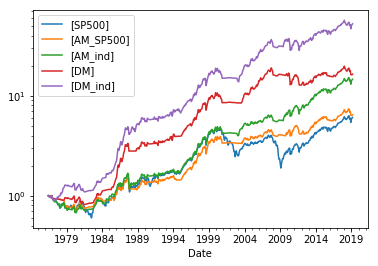

In [12]:
perf['ajusted_value'].plot(logy=True)

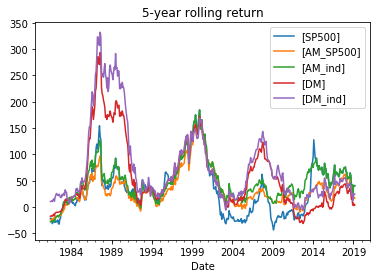

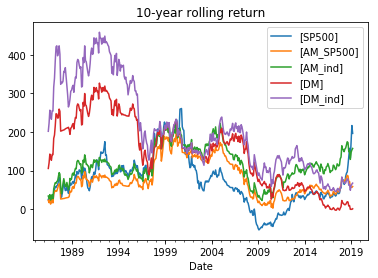

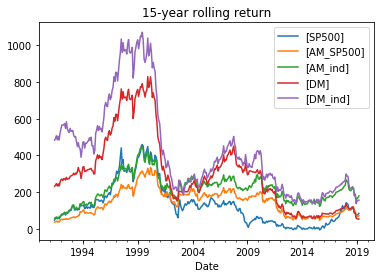

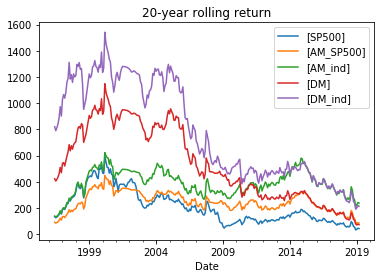

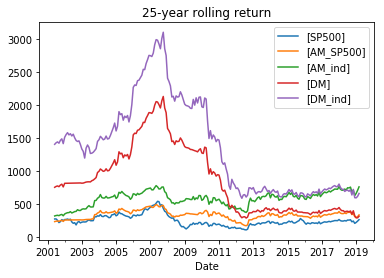

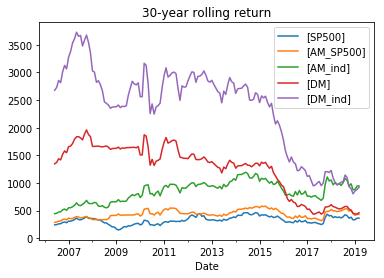

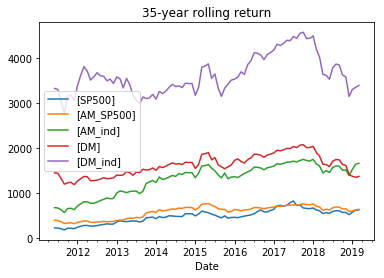

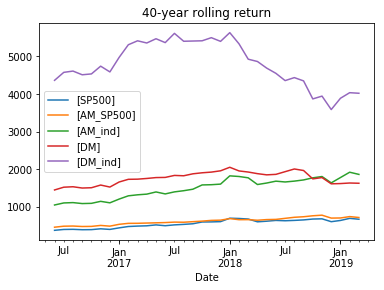

In [13]:
# rolling return
for x in range(5,45,5):
    perf['ajusted_value'].pct_change(12*x).apply(lambda i:i*100).plot(title=str(x) + '-year rolling return')

## (2) Monte Carlo Simulation

In [14]:
# source table for 1-year rolling return
ror1 = perf['ajusted_value'].pct_change(12).dropna().reset_index().drop('Date', axis=1) 
ror1.head()

,[SP500],[AM_SP500],[AM_ind],[DM],[DM_ind]
0,-0.096663,-0.069723,-0.096663,-0.069723,-0.076829
1,-0.103807,-0.059064,-0.103807,-0.059064,-0.081320
2,-0.116421,-0.049084,-0.116421,-0.049084,-0.040816
3,-0.137857,-0.066591,-0.137857,-0.066591,-0.033837
4,-0.159072,-0.044870,-0.159072,-0.044870,0.000809


,index,[SP500],[AM_SP500],[AM_ind],[DM],[DM_ind],index_[SP500],index_[AM_SP500],index_[AM_ind],index_[DM],index_[DM_ind]
0,430,0.127156,0.084324,0.127156,0.052970,0.094563,1.000000,1.000000,1.000000,1.000000,1.000000
1,491,0.090630,0.090630,0.090630,0.008873,0.008873,1.090630,1.090630,1.090630,1.008873,1.008873
2,33,-0.123023,-0.088753,-0.088753,-0.100286,-0.100286,0.956458,0.993834,0.993834,0.907697,0.907697
3,231,0.141168,0.141168,0.141168,0.141168,0.141168,1.091479,1.134131,1.134131,1.035834,1.035834
4,4,-0.159072,-0.044870,-0.159072,-0.044870,0.000809,0.917856,1.083243,0.953723,0.989357,1.036673


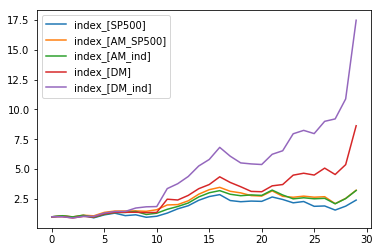

In [15]:
# calculate index for one simulation
df2 = ror1.sample(n=30).reset_index() #get random 30 rows from ror1 table
for i in strategies:
    list = [1,]
    for num in range(1, len(df2)):
        list.append(list[num-1]*(1+df2[i][num]))
    df2['index_' + str(i)] = np.array(list)
    df2['index_' + str(i)].plot(legend=True)
df2.head()

In [16]:
#calculate index for all strategies and show the mean and std
num_simulation=100
mean = pd.DataFrame()
std = pd.DataFrame()

for i in strategies:
    mother_list=[]
    for a in range(num_simulation):
        sample = ror1.sample(n=30).reset_index() #get random 30 rows from ror1 table
        list = [1,] # index value for one simulation
        for num in range(1,len(sample)):# index value for one simulation
            list.append(list[num-1]*(1+sample[i][num]))# index value for one simulation    
        mother_list.append(list) # list to contain data for all simulations
    # after the simulations are completed, construct a dataframe to hold all sets of simulation data:
    simulation = pd.DataFrame()
    for n in range(num_simulation): 
        simulation['sim_'+str(n)] = np.array(mother_list[n])
    # calculate mean and std
    mean[str(i)] = simulation.mean(axis=1)
    std[str(i)] = simulation.std(axis=1)

mean.tail()

,[SP500],[AM_SP500],[AM_ind],[DM],[DM_ind]
25,3.481490,3.633426,5.627278,7.675312,14.238064
26,3.764458,3.848544,6.102499,8.108588,15.732183
27,3.968086,4.042434,6.444277,8.785145,17.790540
28,4.098114,4.207159,6.955356,9.662073,19.963034
29,4.443785,4.400399,7.581371,10.396950,22.957657


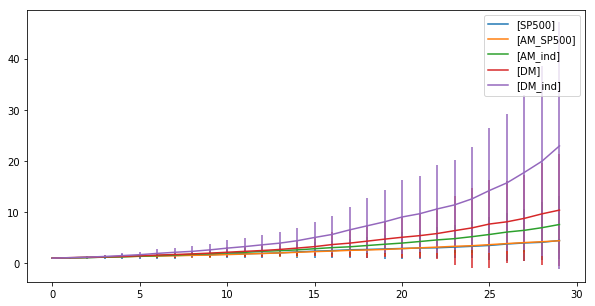

In [17]:
mean.plot(yerr=std, figsize=(10,5))

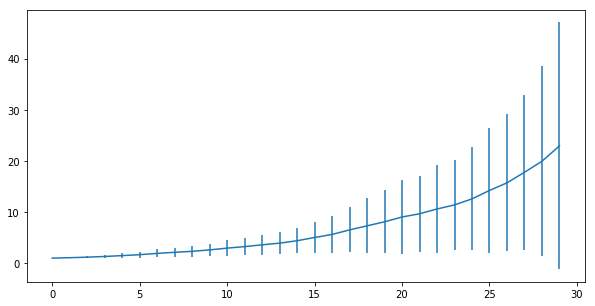

In [18]:
mean['[DM_ind]'].plot(yerr=std['[DM_ind]'], figsize=(10,5))

### Safe Withdraw Rate Simulation

In [19]:
#calculate safe withdraw rate for one simulation
sample_size=30
sample = ror1.sample(n=sample_size).reset_index() #get random 30 rows from ror1 table
swr = []
for i in strategies: 
    list = []
    list.append(1 + sample[i][sample_size-1]) #list[0]
    for x in range(sample_size-1):
        list.append( list[x]*(1+ sample[i][sample_size-2-x]) )
    rate = (list[sample_size-1]/list[0]-1)/(np.sum(list[1:])/list[0])
    swr.append(rate)
    sample['backtrace_' + str(i)] = np.array(list)

In [20]:
# run many simulations
num_simulation=1000
sample_size=30
simulation_swr = pd.DataFrame(index=strategies)

for z in range(num_simulation):
    sample = ror1.sample(n=sample_size).reset_index() #get random 30 rows from ror1 table
    swr = [] # list to hold swr of each strategy
    for i in strategies: 
        list = []
        list.append(1 + sample[i][sample_size-1]) #list[0]
        for x in range(sample_size-1):
            list.append( list[x]*(1+ sample[i][sample_size-2-x]) )
        rate = (list[sample_size-1]/list[0]-1)/(np.sum(list[1:])/list[0])
        swr.append(rate)
    simulation_swr['sim_' + str(z)] = np.array(swr)
simulation_swr = simulation_swr.transpose()
simulation_swr.head()

,[SP500],[AM_SP500],[AM_ind],[DM],[DM_ind]
sim_0,0.118196,0.093147,0.106816,0.090309,0.107704
sim_1,0.073720,0.065055,0.086622,0.139214,0.171113
sim_2,0.010890,0.017009,0.030230,0.034017,0.050147
sim_3,0.025607,0.038919,0.052139,0.048255,0.069118
sim_4,0.072559,0.060719,0.068285,0.096693,0.124896


In [21]:
simulation_swr.describe()

,[SP500],[AM_SP500],[AM_ind],[DM],[DM_ind]
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.042771,0.045425,0.062191,0.065322,0.089108
std,0.028945,0.020245,0.021200,0.026935,0.027928
min,-0.071304,-0.017509,0.003364,-0.002278,0.014950
25%,0.022787,0.031877,0.047389,0.047015,0.069625
50%,0.042219,0.044450,0.060982,0.062408,0.086423
75%,0.061981,0.059332,0.075464,0.081243,0.105984
max,0.134029,0.112051,0.129090,0.168452,0.192861


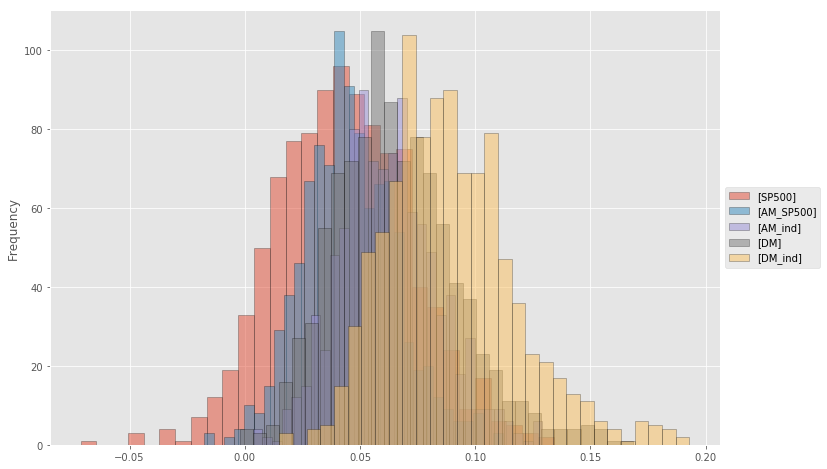

In [22]:
# distribution plot
plt.style.use('ggplot')
for i in strategies:
    simulation_swr[i].plot(kind = 'hist', alpha=0.5, figsize=(12,8), bins=30, edgecolor='black')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

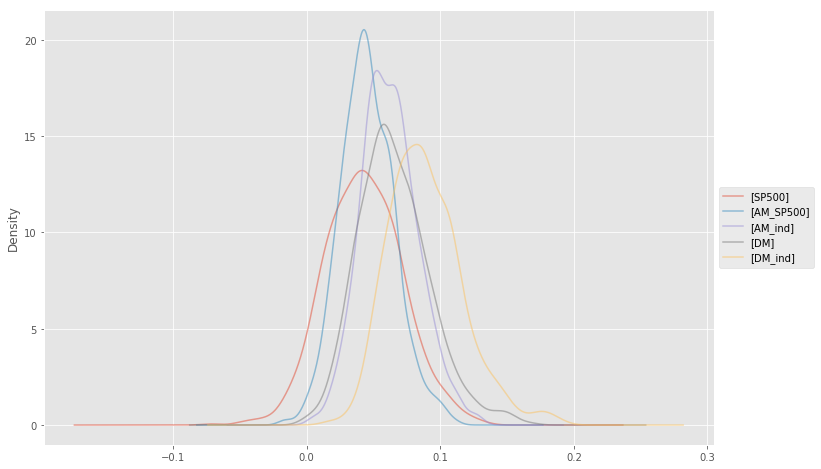

In [23]:
# distribution plot - kernel density
plt.style.use('ggplot')
for i in strategies:
    simulation_swr[i].plot(kind = 'kde', alpha=0.5, figsize=(12,8))
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))